In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Importing benchmark datasets
Datasets are kept constant for benchmarking across the models in order to promote accurate comparison

In [ ]:
file_path_X= '/content/X.csv_final'
X = pd.read_csv(file_path_X)

file_path_y = '/content/y.csv_final'
y = pd.read_csv(file_path_y)

file_path_X_test = '/content/X_test_final.csv'
X_test = pd.read_csv(file_path_X_test)

file_path_y_test = '/content/y_test_final.csv'
y_test = pd.read_csv(file_path_y_test)

# Preparing data for training XGBOOst baseline model
The model is built according to architecture specified by Menshawi & Hasssan (2023) https://doi.org/10.1111/exsy.13735. The paper provided the following hyper parameters for XGBoost: Validate_parameters = No, min split loss = 0.005, max depth = 4.

Features were selected for X in line with feature selectino for LLM models to ensure consistency, with additional preprocessing to ensure compatability with XGBoost requirements for data input

In [9]:
#isolating features of interest for triaging
X = X[["AGE", "SEX", "ARREMS", "RFV1", "TEMPF", "PULSE", "BPSYS", "BPDIAS", "RESPR", "POPCT", "PAINSCALE", "TOTCHRON", "INJURY", "HTN", "ETOHAB", "CANCER", "DEPRN"]]
X_test = X_test [["AGE", "SEX", "ARREMS", "RFV1", "TEMPF", "PULSE", "BPSYS", "BPDIAS", "RESPR", "POPCT", "PAINSCALE", "TOTCHRON", "INJURY", "HTN", "ETOHAB", "CANCER", "DEPRN"]]

In [10]:
#Converting features into data type usable by the model - converting object columns to numeric or categorical
for col in ["AGE", "SEX", "ARREMS", "RFV1", "TEMPF", "PULSE", "BPSYS", "BPDIAS", "RESPR", "POPCT", "PAINSCALE", "TOTCHRON", "INJURY", "HTN", "ETOHAB", "CANCER", "DEPRN"]:
    if X[col].dtype == 'object':
        try:
            X[col] = pd.to_numeric(X[col])
            X_test[col] = pd.to_numeric(X_test[col])
        except ValueError:
            X[col] = X[col].astype('category')
            X_test[col] = X_test[col].astype('category')
X = X[["AGE", "SEX", "ARREMS", "RFV1", "TEMPF", "PULSE", "BPSYS", "BPDIAS", "RESPR", "POPCT", "PAINSCALE", "TOTCHRON", "INJURY", "HTN", "ETOHAB", "CANCER", "DEPRN"]]
X_test = X_test [["AGE", "SEX", "ARREMS", "RFV1", "TEMPF", "PULSE", "BPSYS", "BPDIAS", "RESPR", "POPCT", "PAINSCALE", "TOTCHRON", "INJURY", "HTN", "ETOHAB", "CANCER", "DEPRN"]]

## Building and training the model


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

In [12]:
# model instantiated based on defined hyperparametrs
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',  # for multi-class probabilities
    num_class= 5,                 #5 classes of triage to predict
    gamma=0.005, #defined by paper
    max_depth=4, #defined by paper
    validate_parameters=False, #defined by paper
    eval_metric='mlogloss', #for AUC calc
    enable_categorical=True #for categorised x features
)


In [13]:
#training model
xgb_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, gamma=0.005, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

#Evaluation metrics for comparison across models

Temperature: 0.50, NLL: 2.7137
Temperature: 0.75, NLL: 1.9966
Temperature: 1.00, NLL: 1.6765
Temperature: 1.25, NLL: 1.5099
Temperature: 1.50, NLL: 1.4167
Temperature: 1.75, NLL: 1.3629
Temperature: 2.00, NLL: 1.3322
Temperature: 2.25, NLL: 1.3154
Temperature: 2.50, NLL: 1.3074
Temperature: 2.75, NLL: 1.3051
Temperature: 3.00, NLL: 1.3063
 Optimal Temperature: 2.75, NLL: 1.3051
 Metrics with Temperature Calibration
Accuracy: 0.3892
AUC: 0.5050
Mean Predicted Probability: 0.4312


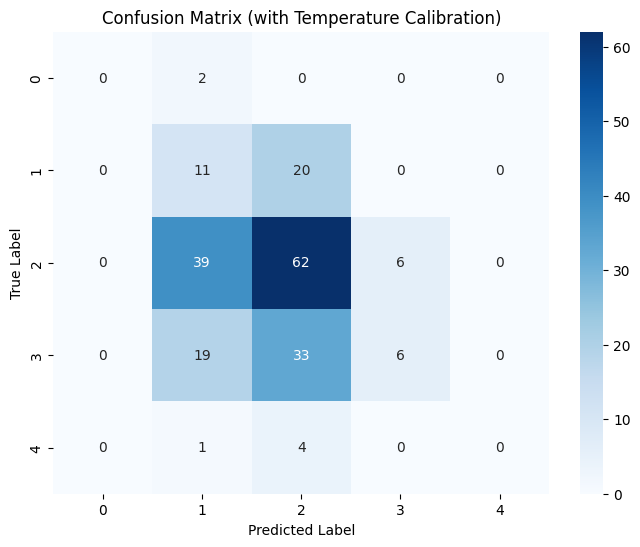

Mean Entropy with Optimal Temperature: 1.3020


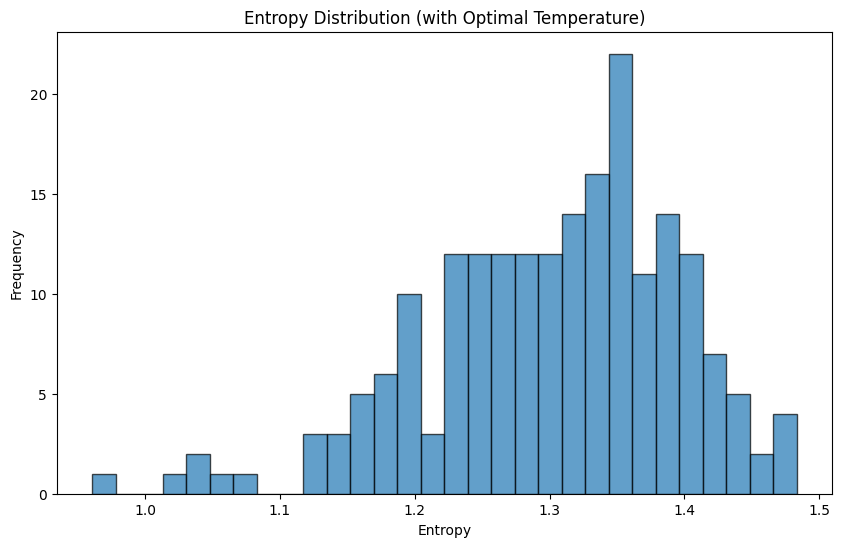

In [14]:
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn.functional as F

# Generating predictions for class probabilities
y_proba = xgb_model.predict_proba(X_test)
y_true = y_test.to_numpy() #convert to numpy array for later conversion to tensor

# Convert softmaxed probabilities to logits for consistency with evaluation metrics
epsilon = 1e-8  # avoids error from log 0
logits = np.log(y_proba + epsilon)

# Convert to torch tensor
logits_tensor = torch.tensor(logits)
labels_tensor = torch.tensor(y_true)

# defining softmax functions with temp scaling acc. to method for languagew models
def apply_temperature(logits, temperature):
    return logits / temperature

def softmax_with_temperature(logits, temperature):
    scaled_logits = apply_temperature(logits, temperature)
    return F.softmax(scaled_logits, dim=1)

def negative_log_likelihood(probs, labels):
    labels = torch.tensor(labels)
    probs_tensor = torch.tensor(probs)
    correct_class_probs = probs_tensor[range(len(labels)), labels]
    nll = -torch.mean(torch.log(correct_class_probs + 1e-8))
    return nll.item()

def find_optimal_temperature(logits, labels, temperature_values):
    best_temp = None
    best_nll = float("inf")
    for temp in temperature_values:
        probs_temp = softmax_with_temperature(logits, temp).detach().numpy()
        nll = negative_log_likelihood(probs_temp, labels)
        print(f"Temperature: {temp:.2f}, NLL: {nll:.4f}")
        if nll < best_nll:
            best_nll = nll
            best_temp = temp
    return best_temp, best_nll

#finding optimal temperature for model perfomance
temperature_values = np.linspace(0.5, 3.0, 11)  # e.g., [0.5, 0.75, ..., 3.0]
optimal_temp, optimal_nll = find_optimal_temperature(logits_tensor, y_true, temperature_values)
print(f" Optimal Temperature: {optimal_temp:.2f}, NLL: {optimal_nll:.4f}")

#calculate optimal probability and prediction functions
optimal_probs = softmax_with_temperature(logits_tensor, optimal_temp).detach().numpy()
optimal_preds = np.argmax(optimal_probs, axis=1)

#Calculate evalution metrics at optimal temperature
accuracy_opt = accuracy_score(y_true, optimal_preds)
auc_opt = roc_auc_score(label_binarize(y_true, classes=list(range(optimal_probs.shape[1]))),
                        optimal_probs, multi_class="ovr", average="weighted")
cm_opt = confusion_matrix(y_true, optimal_preds)
mean_prob_opt = np.mean(np.max(optimal_probs, axis=1))

#print metrics
print(" Metrics with Temperature Calibration")
print(f"Accuracy: {accuracy_opt:.4f}")
print(f"AUC: {auc_opt:.4f}")
print(f"Mean Predicted Probability: {mean_prob_opt:.4f}")

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (with Temperature Calibration)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#calculate entropy
def calculate_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-8), axis=1)

entropy_values = calculate_entropy(optimal_probs)
mean_entropy = np.mean(entropy_values)

#plot entropy across optimal temperature
print(f"Mean Entropy with Optimal Temperature: {mean_entropy:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(entropy_values, bins=30, edgecolor='k', alpha=0.7)
plt.title("Entropy Distribution (with Optimal Temperature)")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()


## Predicting over and under triaging

In [15]:
wrong_mask = optimal_preds != y_true.ravel()
if np.sum(wrong_mask) > 0:
    pct_over = np.mean(optimal_preds[wrong_mask] > y_true[wrong_mask]) * 100
    pct_under = np.mean(optimal_preds[wrong_mask] < y_true[wrong_mask]) * 100
else:
    pct_over = pct_under = 0

print(f"Over-triage: {pct_over:.2f}%")
print(f"Under-triage: {pct_under:.2f}%")


Over-triage: 11.56%
Under-triage: 61.79%
